In [2]:
import sys
sys.path.append('../app')

import os, pickle
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from config import Config
from process_images import WWMRImageProcessor

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

## Train InceptionV3 on WWMR data alone, 2 classes: mask correct/mask incorrect

In [3]:
conf = Config()

#the inception_v3 expects tensors with a size of N x 3 x 299 x 299
conf.im_size =299
conf.tensor_path = '../data/real'

image_proc = WWMRImageProcessor(conf)
im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle = image_proc.load_data()

im_arrays.shape

torch.Size([2934, 3, 128, 128])

In [8]:
# Get class counts for the dataset

print(np.unique(y_binary, return_counts=True))
print(np.unique(y_mask_stat, return_counts=True))
print(np.unique(y_mask_type, return_counts=True))

(array([0, 1], dtype=int64), array([1070,  152], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([152, 152, 241, 152, 152, 113, 152, 108], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([185, 100, 270, 113, 554], dtype=int64))


### Since mask worn correctly is under-represented, flip each of those images and add it to the data

In [4]:
def show_image(im_tensor):
    #unswap the color channel from index 0 (needed for model) back to index 2
    im_tensor = torch.swapaxes(im_tensor, 0, 2)
    
    #denormalize
    im_tensor = ((im_tensor * conf.imnet_std) + conf.imnet_mean) * 255
    
    plt.imshow(im_tensor.numpy().astype(np.int32))
    plt.show()

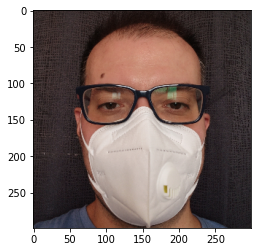

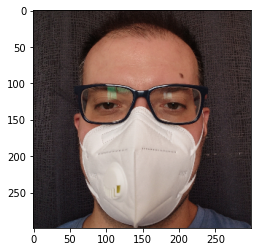

In [14]:
# select positive class and flip, view examples

pos_class_idx = (y_binary==1).nonzero(as_tuple=True)[0]
pos_class_arrays = im_arrays[pos_class_idx]
pos_class_flipped_arrays = torch.flip(pos_class_arrays, dims=(2,))

show_image(pos_class_arrays[0])
show_image(pos_class_flipped_arrays[0])

In [16]:
# add flipped to the positive class data
pos_class_arrays = torch.cat((pos_class_arrays, pos_class_flipped_arrays), 0)
pos_class_arrays.size()

torch.Size([304, 3, 299, 299])

In [17]:
# get negative classes, shuffle, choose number equal to positive class
neg_class_idx = (y_binary==0).nonzero(as_tuple=True)[0]
neg_class_arrays = im_arrays[neg_class_idx]
idx = torch.randperm(neg_class_arrays.size(0))
neg_class_arrays = neg_class_arrays[idx]
neg_class_arrays = neg_class_arrays[:pos_class_arrays.size(0)]
neg_class_arrays.size()

torch.Size([304, 3, 299, 299])

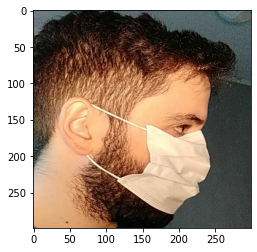

In [18]:
show_image(neg_class_arrays[0])

In [19]:
#combine and shuffle
im_tensors = torch.cat((pos_class_arrays, neg_class_arrays), 0)

#create y_binary
y_binary = torch.tensor([1]*pos_class_arrays.size(0) + [0]*neg_class_arrays.size(0))

idx = torch.randperm(im_tensors.size(0))
im_tensors = im_tensors[idx]
y_binary = y_binary[idx]

im_tensors.size()

torch.Size([608, 3, 299, 299])

In [20]:
#verify they are correct

pos_class_idx = (y_binary==1).nonzero(as_tuple=True)[0]
pos_class_idx[0]

tensor(1)

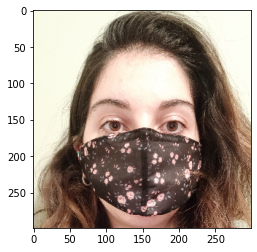

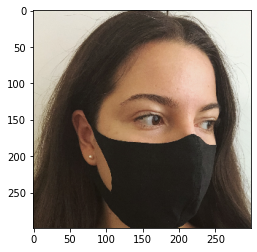

In [21]:
show_image(im_tensors[0])
show_image(im_tensors[1])

In [22]:
#split into train/cross validation/test
lab2idx = {'Not Worn Correctly':0, 'Worn Correctly':1}

x_test = im_tensors[:100]
y_test = y_binary[:100]

x_cv = im_tensors[100:150]
y_cv = y_binary[100:150]

x_train = im_tensors[150:]
y_train = y_binary[150:]

#### Train binary model on mask worn properly or not

In [31]:
#inception v3 has auxillary outputs we don't want
model = models.inception_v3(pretrained=True, aux_logits=False)
model.fc = nn.Linear(2048, 2)

In [32]:
# apply differential learning rates

optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.Mixed_7c.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7b.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7a.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6e.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6d.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6c.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6b.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6a.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_5d.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5c.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5b.parameters(), 'lr': 1e-7}
], lr=1e-8)

In [14]:
def finetune_model(model, optimizer, model_path, lab2idx, 
                   x_train, y_train, x_cv, y_cv, x_test, y_test,
                   device, batch_size=32, n_epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)
    train_losses = []
    cv_losses = []
    
    if not os.path.exists(model_path):
        os.mkdir(model_path)

    best_acc = 0
    
    for epoch in range(n_epochs):
        print('Epoch: %d' % epoch)
        
        idx = torch.randperm(x_train.size(0))
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        ep_ttl = 0
   
        for j in range(0, x_train.size(0), batch_size):
            ep_ttl += 1
            x_batch = x_train[j:j+batch_size].to(device)
            y_batch = y_train[j:j+batch_size].to(device)

            #reset gradient for this iteration
            optimizer.zero_grad()

            #run the data through the model
            output = model(x_batch)

            #get the negative log likelihood loss
            loss = criterion(output, y_batch)

            #calculate the gradients
            loss.backward()

            #update the parameters from the gradients
            optimizer.step()

            if ep_ttl%50==0:
                print('Epoch: %d, Batch: %d, Loss: %.6f' % (epoch, j, loss.item()))
                train_losses.append(loss.item())

        ##### more testing, used to be at epoch level
        print('Testing model...')
        acc, cv_loss = test(model, criterion, x_cv, y_cv, lab2idx)
        scheduler.step(cv_loss)
        cv_losses.append(cv_loss)
        print('CV accuracy %.6f, prev best acc: %.6f %s' % (acc, best_acc, '!! IMPROVED !!' if acc>best_acc else ''))

        if acc>best_acc:
            best_acc = acc
            no_improvement = 0
            print('Saving model...')
            torch.save(model.state_dict(), '%s/model.pt' % model_path)
            torch.save(optimizer.state_dict(), '%s/optimizer.pt' % model_path)
        else:
            no_improvement += 1

        if no_improvement >= 50:
            print('no improvement in several epochs, breaking')
            break
            
    model.load_state_dict(torch.load('%s/model.pt' % model_path))
    test_acc, _ = test(model, criterion, x_test, y_test, lab2idx, True)
    print('final test accuracy: %.6f' % test_acc)
    model.eval()
    
    return model, train_losses, cv_losses

            
def test(model, criterion, x_test, y_test, lab2idx, print_report=False):
    model.eval()
    
    correct = 0
    loss = 0
    with torch.no_grad():
        output = model(x_test)
        
        loss = criterion(output, y_test)
        
        #select the indices of the maximum output values/prediction
        _, y_pred = torch.max(output, 1)

        #compare them with the target digits and sum correct predictions
        correct = y_pred.eq(y_test).sum()
        
    acc = correct / y_test.size()[0]
    
    print('Test accuracy %.6f, %d of %d' % (acc, correct, y_test.size(0)))
    
    if print_report:
        idx2lab = {v:k for k,v in lab2idx.items()}
        class_labels = [idx2lab[i] for i in range(len(idx2lab))]
        
        print('\n\n')
        print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
        print('\n\n')
    
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        fig, ax = plt.subplots(figsize=(12,10))
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    
    model.train()
    
    return acc, loss.item()

Epoch: 0
Epoch: 0, Batch: 392, Loss: 0.415450
Testing model...
Test accuracy 0.700000, 35 of 50
CV accuracy 0.700000, prev best acc: 0.000000 !! IMPROVED !!
Saving model...
Epoch: 1
Epoch: 1, Batch: 392, Loss: 0.044946
Testing model...
Test accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.700000 !! IMPROVED !!
Saving model...
Epoch: 2
Epoch: 2, Batch: 392, Loss: 0.051420
Testing model...
Test accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.780000 
Epoch: 3
Epoch: 3, Batch: 392, Loss: 0.022439
Testing model...
Test accuracy 0.760000, 38 of 50
CV accuracy 0.760000, prev best acc: 0.780000 
Epoch: 4
Epoch: 4, Batch: 392, Loss: 0.053512
Testing model...
Test accuracy 0.840000, 42 of 50
CV accuracy 0.840000, prev best acc: 0.780000 !! IMPROVED !!
Saving model...
Epoch: 5
Epoch: 5, Batch: 392, Loss: 0.002142
Testing model...
Test accuracy 0.820000, 41 of 50
CV accuracy 0.820000, prev best acc: 0.840000 
Epoch: 6
Epoch: 6, Batch: 392, Loss: 0.007159
Testin

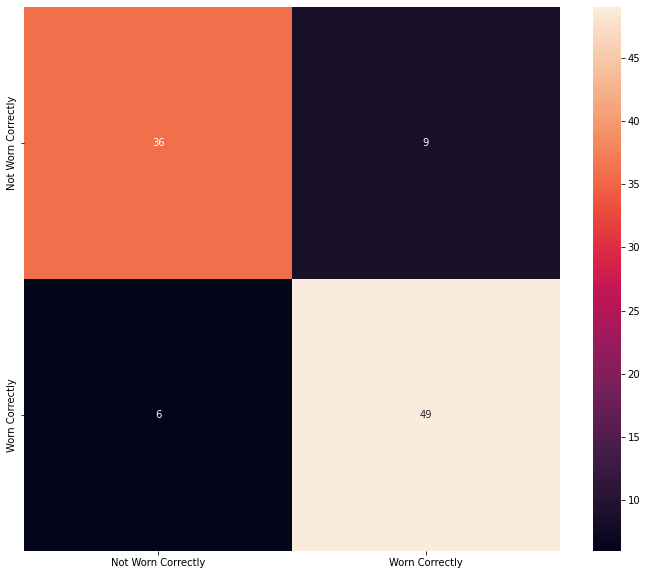

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = 'inceptionv3_model'

model, train_losses, cv_losses = finetune_model(model, optimizer, model_path, lab2idx,
                                                x_train, y_train, x_cv, y_cv, x_test, y_test,
                                                device, batch_size=8, n_epochs=50)

In [35]:
model.load_state_dict(torch.load('%s/model.pt' % model_path))

<All keys matched successfully>

Test accuracy 0.850000, 85 of 100



                    precision    recall  f1-score   support

Not Worn Correctly     0.8571    0.8000    0.8276        45
    Worn Correctly     0.8448    0.8909    0.8673        55

          accuracy                         0.8500       100
         macro avg     0.8510    0.8455    0.8474       100
      weighted avg     0.8504    0.8500    0.8494       100






(tensor(0.8500), 0.4621315002441406)

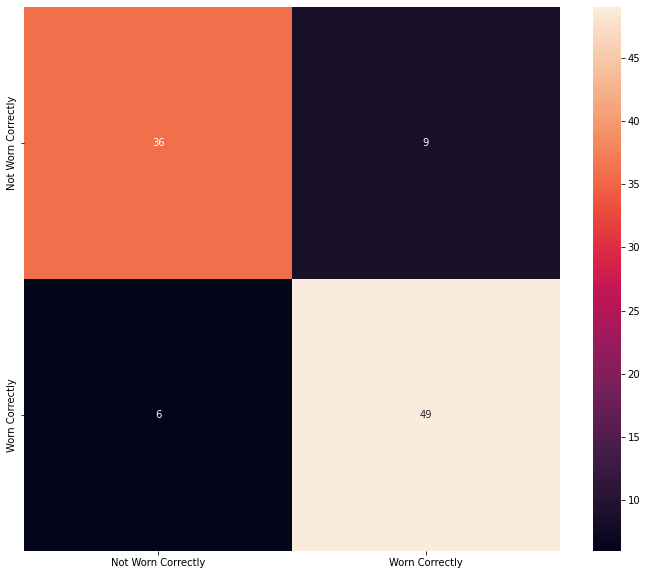

In [36]:
criterion = nn.CrossEntropyLoss()
test(model, criterion, x_test, y_test, lab2idx, print_report=True)

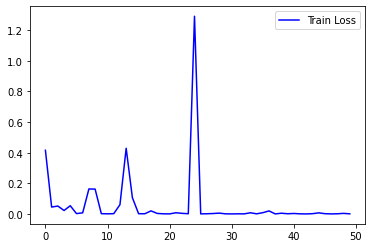

In [37]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')

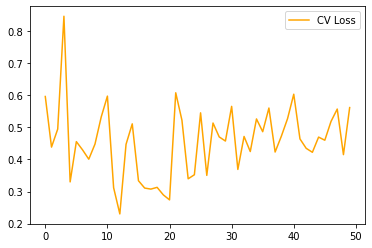

In [38]:
fig = plt.figure()
plt.plot(cv_losses, color='orange')

plt.legend(['CV Loss'], loc='upper right')

#### The training set is really too small. In the notebook create_combined_dataset a 3 class (no mask, correct mask, incorrect mask) dataset is created with close to 1K samples per class.

## Train GoogLeNet on 3 class combined dataset

In [ ]:
im_size = 128
path = '../data/combined_3class'

im_arrays = torch.load('%s/x_%d.pt' % (path, conf.im_size))
y_3class = torch.load('%s/y.pt' % (path))
with open('%s/im_names.txt' % (path), 'r') as f:
    im_names = f.read().split('\n')
    
im_arrays.shape

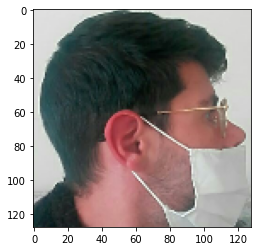

In [5]:
show_image(im_arrays[0])

In [7]:
# load 3 class label to index map
with open('%s/lab2idx.pkl' % path, 'rb') as f:
    lab2idx = pickle.load(f)
lab2idx

{'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

In [10]:
# divide data into train/crossval/test

x_test = im_arrays[:300]
y_test = y_3class[:300]
test_im_names = im_names[:300]

x_cv = im_arrays[300:400]
y_cv = y_3class[300:400]
cv_im_names = im_names[300:400]

x_train = im_arrays[400:]
y_train = y_3class[400:]
train_im_names = im_names[400:]

x_train.shape, x_cv.shape, x_test.shape

(torch.Size([2534, 3, 128, 128]),
 torch.Size([100, 3, 128, 128]),
 torch.Size([300, 3, 128, 128]))

In [11]:
model = models.googlenet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Collins/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
model.fc = nn.Linear(1024, len(lab2idx))

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Epoch: 0


c:\ml\env\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 0, Batch: 392, Loss: 0.592909
Epoch: 0, Batch: 792, Loss: 0.550427
Epoch: 0, Batch: 1192, Loss: 0.204320
Epoch: 0, Batch: 1592, Loss: 0.319218
Epoch: 0, Batch: 1992, Loss: 0.199377
Epoch: 0, Batch: 2392, Loss: 0.250838
Testing model...
Test accuracy 0.890000, 89 of 100
CV accuracy 0.890000, prev best acc: 0.000000 !! IMPROVED !!
Saving model...
Epoch: 1
Epoch: 1, Batch: 392, Loss: 0.151056
Epoch: 1, Batch: 792, Loss: 0.336471
Epoch: 1, Batch: 1192, Loss: 0.098283
Epoch: 1, Batch: 1592, Loss: 0.351546
Epoch: 1, Batch: 1992, Loss: 0.261346
Epoch: 1, Batch: 2392, Loss: 0.414685
Testing model...
Test accuracy 0.900000, 90 of 100
CV accuracy 0.900000, prev best acc: 0.890000 !! IMPROVED !!
Saving model...
Epoch: 2
Epoch: 2, Batch: 392, Loss: 0.094756
Epoch: 2, Batch: 792, Loss: 0.332597
Epoch: 2, Batch: 1192, Loss: 0.191236
Epoch: 2, Batch: 1592, Loss: 0.104044
Epoch: 2, Batch: 1992, Loss: 0.285784
Epoch: 2, Batch: 2392, Loss: 0.216526
Testing model...
Test accuracy 0.930000, 93 of 1

Epoch: 24, Batch: 392, Loss: 0.001475
Epoch: 24, Batch: 792, Loss: 0.002799
Epoch: 24, Batch: 1192, Loss: 0.000409
Epoch: 24, Batch: 1592, Loss: 0.000162
Epoch: 24, Batch: 1992, Loss: 0.001023
Epoch: 24, Batch: 2392, Loss: 0.000125
Testing model...
Test accuracy 0.950000, 95 of 100
CV accuracy 0.950000, prev best acc: 0.970000 
Epoch: 25
Epoch: 25, Batch: 392, Loss: 0.000041
Epoch: 25, Batch: 792, Loss: 0.000198
Epoch: 25, Batch: 1192, Loss: 0.002820
Epoch: 25, Batch: 1592, Loss: 0.000715
Epoch: 25, Batch: 1992, Loss: 0.001353
Epoch: 25, Batch: 2392, Loss: 0.003775
Testing model...
Test accuracy 0.970000, 97 of 100
CV accuracy 0.970000, prev best acc: 0.970000 
Epoch: 26
Epoch: 26, Batch: 392, Loss: 0.004572
Epoch: 26, Batch: 792, Loss: 0.000744
Epoch: 26, Batch: 1192, Loss: 0.000536
Epoch: 26, Batch: 1592, Loss: 0.000280
Epoch: 26, Batch: 1992, Loss: 0.000893
Epoch: 26, Batch: 2392, Loss: 0.001528
Testing model...
Test accuracy 0.970000, 97 of 100
CV accuracy 0.970000, prev best acc: 

Epoch: 48, Batch: 792, Loss: 0.000170
Epoch: 48, Batch: 1192, Loss: 0.000201
Epoch: 48, Batch: 1592, Loss: 0.000051
Epoch: 48, Batch: 1992, Loss: 0.001180
Epoch: 48, Batch: 2392, Loss: 0.000038
Testing model...
Test accuracy 0.950000, 95 of 100
CV accuracy 0.950000, prev best acc: 0.970000 
Epoch: 49
Epoch: 49, Batch: 392, Loss: 0.000293
Epoch: 49, Batch: 792, Loss: 0.000173
Epoch: 49, Batch: 1192, Loss: 0.000100
Epoch: 49, Batch: 1592, Loss: 0.000218
Epoch: 49, Batch: 1992, Loss: 0.002131
Epoch: 49, Batch: 2392, Loss: 0.000802
Testing model...
Test accuracy 0.950000, 95 of 100
CV accuracy 0.950000, prev best acc: 0.970000 
Test accuracy 0.950000, 285 of 300



                       precision    recall  f1-score   support

         without_mask     0.9565    0.9670    0.9617        91
            with_mask     0.9914    0.9426    0.9664       122
mask_weared_incorrect     0.8913    0.9425    0.9162        87

             accuracy                         0.9500       300
            m

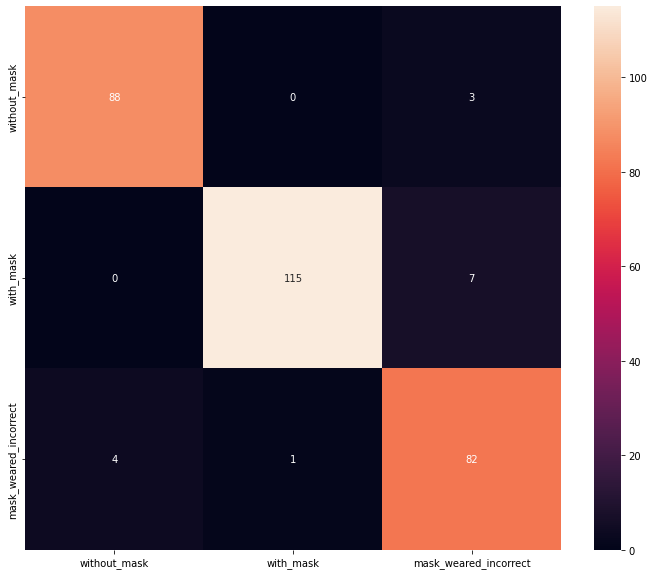

In [15]:
# train model and store when crossval score increases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = 'googlenet_3class_model'

model, train_losses, cv_losses = finetune_model(model, optimizer, model_path, lab2idx,
                                                x_train, y_train, x_cv, y_cv, x_test, y_test,
                                                device, batch_size=8, n_epochs=50)

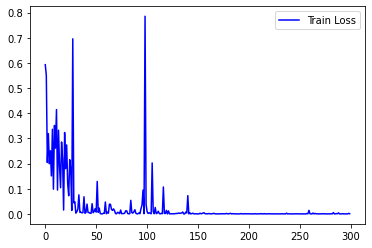

In [16]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')

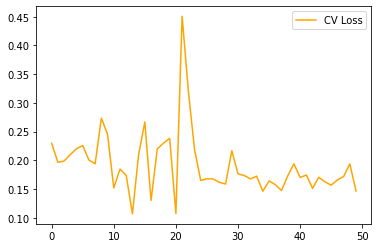

In [17]:
fig = plt.figure()
plt.plot(cv_losses, color='orange')

plt.legend(['CV Loss'], loc='upper right')

### Visualize incorrect predictions

In [20]:
model.eval()
with torch.no_grad():
    output = model(x_test)
    
    #select the indices of the maximum output values/prediction
    _, y_pred = torch.max(output, 1)

    #compare them with the target digits and sum correct predictions
    correct = y_pred.eq(y_test)

wrong_idx = (correct==False).nonzero(as_tuple=True)[0]
wrong_idx

tensor([  8,  36,  37,  62,  80,  84,  92, 147, 149, 211, 223, 246, 254, 273,
        278])



maksssksksss592.png - predicted: mask_weared_incorrect, ground truth: with_mask


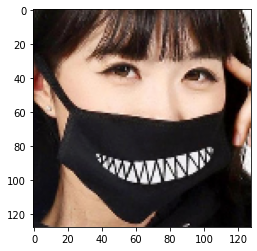



0040_MRCW_NMDM_0090 - predicted: mask_weared_incorrect, ground truth: with_mask


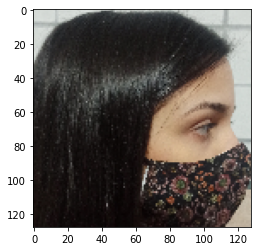



0016_MRCW_NMDM_0045 - predicted: mask_weared_incorrect, ground truth: with_mask


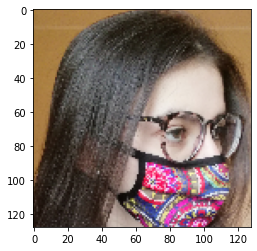



0005_MRNW_0090 - predicted: mask_weared_incorrect, ground truth: without_mask


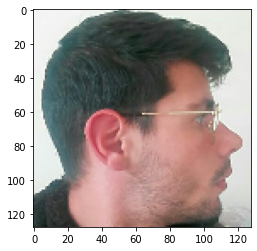



maksssksksss810.png - predicted: mask_weared_incorrect, ground truth: with_mask


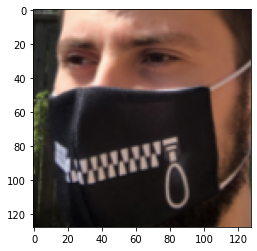



0040_MRCW_NMDM_0045 - predicted: mask_weared_incorrect, ground truth: with_mask


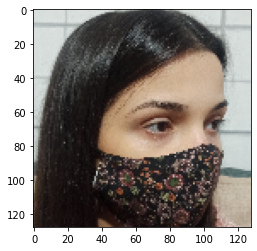



0006_MRNW_0090 - predicted: mask_weared_incorrect, ground truth: without_mask


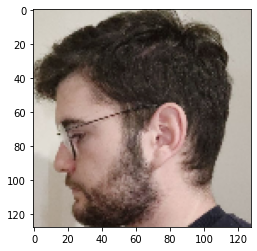



0010_MRHN_SRGM_0090_B - predicted: without_mask, ground truth: mask_weared_incorrect


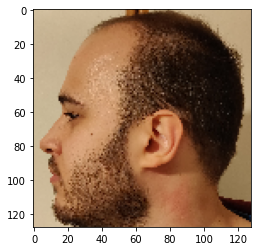



0001_MRCW_DRWV_0090 - predicted: mask_weared_incorrect, ground truth: with_mask


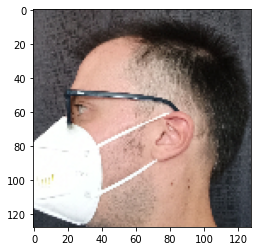



0035_MRHN_NMDM_0045_B - predicted: without_mask, ground truth: mask_weared_incorrect


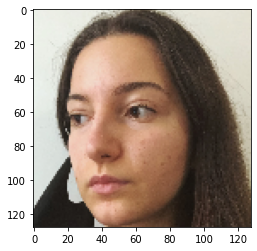



0025_MSFC_SRGM_0045 - predicted: with_mask, ground truth: mask_weared_incorrect


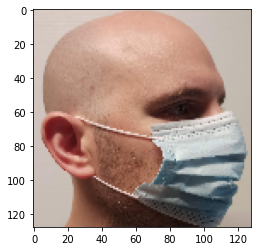



0015_MRHN_DRNV_0090_B - predicted: without_mask, ground truth: mask_weared_incorrect


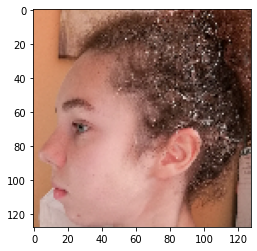



0006_MRCW_DRNV_0045 - predicted: mask_weared_incorrect, ground truth: with_mask


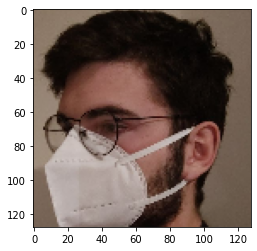



0004_MRHN_DRNV_0090_B - predicted: without_mask, ground truth: mask_weared_incorrect


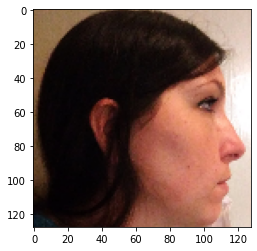



0041_MRNW_0000 - predicted: mask_weared_incorrect, ground truth: without_mask


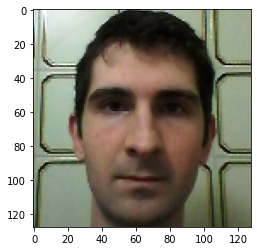

In [22]:
idx2lab = {v:k for k,v in lab2idx.items()}

for idx in wrong_idx.tolist():
    im = x_test[idx]
    corr = y_test[idx].item()
    pred = y_pred[idx].item()
    nm = test_im_names[idx]
    print('\n\n%s - predicted: %s, ground truth: %s' % (nm, idx2lab[pred], idx2lab[corr]))
    show_image(im)

#### The first incorrect prediction looks questionable, her mask looks fairly loose. There are 4 instances where the mask was hanging from the ear on the opposite side of the head and barely visible in the image, so those are questionable results also. 
#### Some of the mistakes may have been due to the images not being cropped perfectly. There are 2 instances of 90 degree faces with no masks where incorrectly worn mask was predicted, and I believe these are due to the images in the training set where the head was angled 90 degrees and the mask was hanging from the ear opposite the camera. Removing these from the training data may improve accuracy. 